# Comparing the CDIPS sum of lightcurves to our own

[CDIPS](https://archive.stsci.edu/hlsp/cdips#section-65c131d0-9994-46e6-a370-af9f2e3669cc) is a catalog of lightcurves that were extracted from stars likely to be in open clusters. We want to download these lightcurves and add them together to get the total lightcurve of the cluster. Then we would like to compare that to the lighcurve we observe with our method, described in the **cluster-lightcurves** directory. Finally, we can display the CDIPS stars on the TPF of the cluster to see where variations might be coming from.

The steps are as follows.

Part 1: getting the CDIPS lightcurve
1. Pick a cluster to study
1. Download a list of nearby TIC stars and filter it by magnitude
1. Download the CDIPS lightcurves and cut those that correspond to stars which are too dim
1. Add together all the remaining CDIPS lightcurves to get the cluster lightcurve

Part 2: getting our lightcurve
1. Download the lightcurve TPF of the entire sector
1. Make a star and sky map
1. Extract the lightcurve from it
1. Display this lightcurve and the CDIPS lightcurve together

Part 3: display CDIPS stars on the cluster
1. Use others' code to convert the angular positions of the CDIPS stars to pixel positions on the TPF
1. Draw the stars on the TPF.

We will put all these functions in a class so that they can be executed for an arbitrary number of clusters without running out of memory.

In [1]:
%matplotlib inline
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
from tess_stars2px import tess_stars2px_function_entry as tess_stars2px
import os

from astropy import log
log.setLevel('WARNING')

LIGHTKURVE_CACHE = "/home/jtdinsmo/.lightkurve-cache/tesscut/"
FFI_SIZE_PIXELS = 180
MAGNITUDE_CUTOFF = 13
ANGLE_ERROR = 0.0001 # Distance apart stars are allowed to be to be considered "equivalent" (degrees)
SEARCH_RADIUS = "0.5 deg"
CDIPS_BIN_WIDTH = 0.08 # Width of time bins for summing the CDIPS lightcurves
LOWER_LIMIT = 10 # Lower limit on flux allowed to be in the sky map
NUMBER_PCA_COMPONENTS = 10
SCALE_FACTOR = 1.5 # Proportionality constant relating number of star pixels and number of maxima

COORDS = {"M34":(40.53083, 42.74615), "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 2391": (130.133, -53.033), 
          "NGC 6231":(253.53546, -41.82667), "Lambda Orionis":(83.784490, 9.934156), "NGC 3532":(166.44923, -58.7705),
          "Collinder 140":("111.113000", "-31.850000"),
          "Omega Cen": (201.69121, -47.47686), "47 Tuc": (6.022329, -72.081444), "NGC 6752": (287.71575, -59.98185)}

Error initializing plugin EntryPoint(name='Windows (alt)', value='keyrings.alt.Windows', group='keyring.backends').
Traceback (most recent call last):
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/keyring/backend.py", line 203, in _load_plugins
    init_func = ep.load()
  File "/home/jtdinsmo/.local/lib/python3.6/site-packages/importlib_metadata/__init__.py", line 105, in load
    module = import_module(match.group('module'))
  File "/usr/lib/python3.6/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 994, in _gcd_import
  File "<frozen importlib._bootstrap>", line 971, in _find_and_load
  File "<frozen importlib._bootstrap>", line 955, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 665, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_

In order for our method to extract the cluster lightcurve to work, we need to create a function that can count the maxima in an image.

In [2]:
def countMaxima(data):
    stars = 0
    
    def getValue(x, y):
        if x < 0 or x >= data.shape[0] or y < 0 or y >= data.shape[0]:
            return 0 # Count this pixel as automatically smaller than everything else
        if np.isnan(data[x][y]):
            return 0 # Count this pixel as automatically smaller than everything else.
        if data[x][y] < LOWER_LIMIT:
            return 0 # Count this pixel as automatically smaller than everything else.
        return data[x][y]
        
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            b = data[x][y]
            if np.isnan(b): continue # Don't count nan pixels
            if b < LOWER_LIMIT: continue # Don't count pixels on edge of sector
            up = getValue(x, y-1)
            down = getValue(x, y+1)
            left = getValue(x-1, y)
            right = getValue(x+1, y)
            if b > max(up, down, left, right):
                stars += 1
    return stars

Now, we can implement all the functions described at the beginning.

In [3]:
class Cluster:
    def __init__(self, name): # 1.1
        self.name = name
        self.clusterCoords = SkyCoord(COORDS[self.name][0], COORDS[self.name][1], unit='deg')
        self.cdipsTimes = None
        self.correctedLC = None
    
    
    def downloadTICStars(self): # 1.2
        self.catalogData = Catalogs.query_region(self.clusterCoords, radius=SEARCH_RADIUS, catalog="TIC")
        self.catalogData = self.catalogData[self.catalogData["Tmag"] < MAGNITUDE_CUTOFF]
        
    
    def downloadCDIPSLightcurves(self):# 1.3
        obs_table = Observations.query_criteria(objectname=self.name, radius=SEARCH_RADIUS, provenance_name="CDIPS")

        # Trim cdips stars
        i = 0
        while i < len(obs_table):
            starFound = False
            for j in range(len(self.catalogData['ra'])):
                if abs(obs_table[i]['s_ra'] - self.catalogData[j]['ra']) <= ANGLE_ERROR:
                    if abs(obs_table[i]['s_dec'] - self.catalogData[j]['dec']) <= ANGLE_ERROR:
                        starFound = True
                        break
            if not starFound:
                del obs_table[i]
                i -= 1
            i += 1
        
        print("There are " + str(len(obs_table)) + " CDIPS stars")
        cdips_products = Observations.get_product_list(obs_table);
        self.cdipsCurves = Observations.download_products(cdips_products);
        
        # Trim TIC stars
        i = 0
        while i < len(self.catalogData):
            starFound = False
            for j in range(len(obs_table['s_ra'])):
                if abs(obs_table[j]['s_ra'] - self.catalogData[i]['ra']) <= ANGLE_ERROR:
                    if abs(obs_table[j]['s_dec'] - self.catalogData[i]['dec']) <= ANGLE_ERROR:
                        starFound = True
                        break
            if not starFound:
                del self.catalogData[i]
                i -= 1
            i += 1
            
        
    def addCDIPSLightcurves(self): # 1.4
        minTime = -1
        maxTime = -1

        for i in range(len(self.cdipsCurves)):
            try:
                hdu = fits.open(self.cdipsCurves[i]['Local Path'])
                if minTime == -1:
                    minTime = min(hdu[1].data['TMID_BJD'])
                    maxTime = max(hdu[1].data['TMID_BJD'])
                else:
                    minTime = max(min(hdu[1].data['TMID_BJD']), minTime)
                    maxTime = min(max(hdu[1].data['TMID_BJD']), maxTime)
            except:
                print("Failed to open manifest {0}".format(i))

        # Set up the bins
        self.cdipsTimes = []
        counter = minTime
        self.timeOrigin = (minTime // 1000) * 1000
        self.timeOrigin -= 1000
        while counter < maxTime:
            self.cdipsTimes.append(counter - self.timeOrigin)
            counter += CDIPS_BIN_WIDTH
        self.cdipsTimes.append(maxTime - self.timeOrigin)

        self.cdipsFluxes = [0] * len(self.cdipsTimes)

        # Add all the light curves
        for i in range(len(self.cdipsCurves)):
            for j in range(len(hdu[1].data['TMID_BJD'])):
                timeIndex = int((hdu[1].data['TMID_BJD'][j] - minTime) / CDIPS_BIN_WIDTH)
                self.cdipsFluxes[timeIndex] += hdu[1].data['PCA1'][j]

        # Remove all the bins with too little flux
        CUTOFF_PERCENTILE = 40

        cutoff = np.percentile(self.cdipsFluxes, CUTOFF_PERCENTILE)
        i = 0
        while i < len(self.cdipsFluxes):
            if(self.cdipsFluxes[i] < cutoff):
                del self.cdipsFluxes[i]
                del self.cdipsTimes[i]
                i-=1
            i+= 1


    # PART 2

    def downloadClusterTPF(self): # 2.1
        foundLocal = False
        self.tpf = None

        for file in os.listdir(LIGHTKURVE_CACHE):
            if file.endswith("180x180_astrocut.fits"): # Confirm size
                if self.clusterCoords.ra.value == float(file.split("_")[-4]): # Confirm RA
                    if self.clusterCoords.dec.value == float(file.split("_")[-3]): # Confirm dec
                        self.tpf = lk.TessTargetPixelFile(LIGHTKURVE_CACHE + file)
                        foundLocal = True
                        break

        if not foundLocal:
            search = lk.search_tesscut(name)
            char = ""
            if len(search) != 1: char = "s"
            print("{0} has {1} result{2}.".format(self.name, len(search), char))
            self.tpf = search[0].download(cutout_size=180)

        self.image = np.mean(self.tpf.flux, axis=0)


    def makeMasks(self): # 2.2
        numMaxima = countMaxima(self.image)
        notNanMask = ~np.isnan(self.image)
        notEdgeMask = self.image > LOWER_LIMIT
        numPixels = np.count_nonzero(notNanMask & notEdgeMask) # Count the number of pixels that
            # are not nan and are greater than LOWER_LIMIT.
        n = 100 - SCALE_FACTOR * numMaxima / numPixels * 100
        upperLimit = np.nanpercentile(self.image, n)# Upper limit of the sky pixel flux range

        self.skyMask = ((self.image >= LOWER_LIMIT) & # Exclude edge pixels
            (self.image <= upperLimit)).reshape(180, 180).astype(bool)
        self.starMask = ((self.image > upperLimit)).reshape(180, 180).astype(bool)


    def extractOurLightcurve(self): # 2.3
        self.lc = self.tpf.to_lightcurve(aperture_mask=self.starMask)

        regressor = self.tpf.flux[:, self.skyMask]# The regressor is the inverse of the aperture

        dm = lk.DesignMatrix(regressor, name='regressors').pca(NUMBER_PCA_COMPONENTS).append_constant()
        corrector = lk.RegressionCorrector(self.lc)
        self.correctedLC = corrector.correct(dm)


    def drawLightcurves(self): # 2.4
        fig, ax = plt.subplots(ncols=1, figsize=(15,6))

        if self.cdipsTimes == None:
            ax.plot(self.correctedLC.time, self.correctedLC.flux, marker='.')
        elif self.correctedLC == None:
            ax.plot(self.cdipsTimes, self.cdipsFluxes, marker='.')
        else:
            newOurFlux = self.correctedLC.flux - np.mean(self.correctedLC.flux)
            newCDIPSFlux = self.cdipsFluxes - np.mean(self.cdipsFluxes)
            newOurFlux /= np.std(newOurFlux)
            newCDIPSFlux /= np.std(newCDIPSFlux)
            ax.plot(self.correctedLC.time, newOurFlux, marker='.')
            ax.plot(self.cdipsTimes, newCDIPSFlux, marker='.')
            

        ax.set_xlabel('Time - ' + str(self.timeOrigin) + '(BJD)');
        ax.set_ylabel('Flux');
        ax.set_title("Lightcurves for {0}".format(self.name));
        ax.legend(["CDIPS"], ["Ours"])
        
        
    # Part 3
    
    def getPixelPos(self, ra, dec, ticid):
        sector = self.tpf.header['sector']
        
        star_dat = tess_stars2px(ticid, ra, dec, trySector=sector)
        colStarPix = star_dat[6]
        rowStarPix = star_dat[7]
        
        cluster_dat = tess_stars2px(6789998212, self.clusterCoords.ra.value,
                                    self.clusterCoords.dec.value, trySector=sector)# What is this?
        colClusterPix = cluster_dat[6]
        rowClusterPix = cluster_dat[7]
        
        x = int((colStarPix - colClusterPix) + FFI_SIZE_PIXELS // 2)
        y = int((rowStarPix - rowClusterPix) + FFI_SIZE_PIXELS // 2)
        
        return (x, y)
        
        
    def drawCDIPSStarsOnTPF(self): # 3.2
        frame = self.tpf.flux.shape[0]//2
        image = self.tpf.flux[frame]
        
        fig, ax1 = plt.subplots(ncols=1, figsize=(11,11))
        c = ax1.imshow(image, vmax = np.nanpercentile(image, 95));
        ax1.set_title(self.name + " tpf")
        plt.colorbar(c, ax=ax1)

        for i in range(len(self.catalogData)):
            ra = self.catalogData[i]["ra"]
            dec = self.catalogData[i]["dec"]
            ticid = self.catalogData[i]["ID"]

            x, y = self.getPixelPos(ra, dec, ticid)
            ax1.scatter(x, y, s=50, c='r')

Now we can actually run the code, using whatever cluster we want.

Trying NGC 6231
There are 179 CDIPS stars


Failed to open manifest 1


/home/jtdinsmo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:164: UserWarning: Legend does not support 'CDIPS' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
/home/jtdinsmo/.local/lib/python3.6/site-packages/lightkurve/targetpixelfile.py:124: LightkurveWarning: `TargetPixelFile.header` is deprecated, please use `TargetPixelFile.get_header()` instead.
  LightkurveWarning)


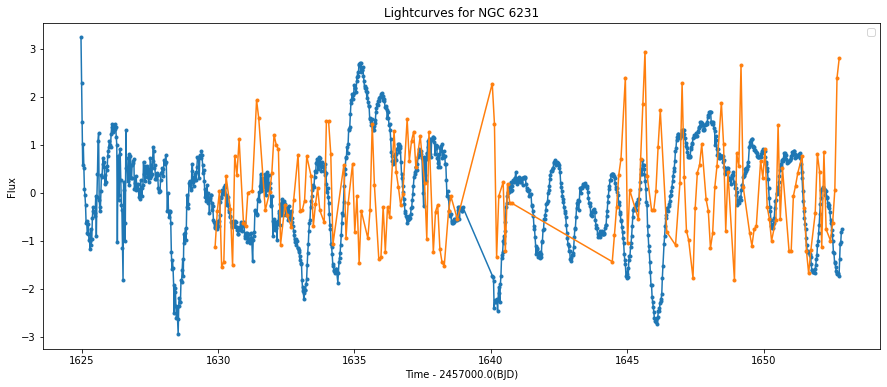

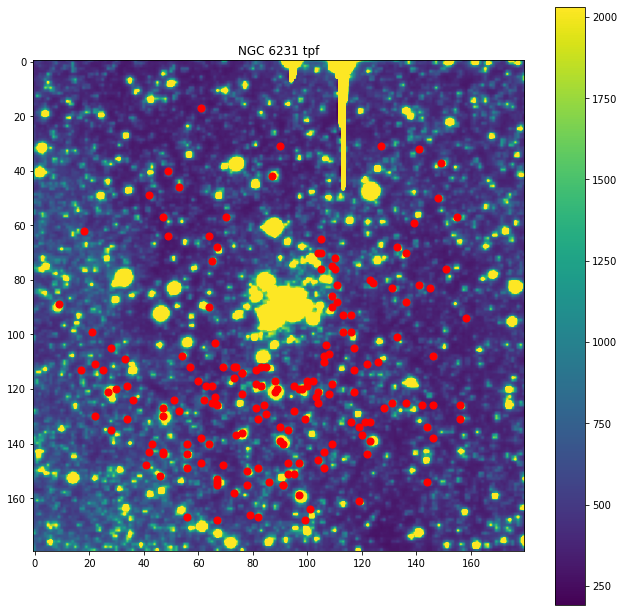

In [4]:
for name in ["NGC 6231"]:#, "Lambda Orionis", "NGC 3532", "Collinder 140"]:#"NGC 752", "IC 2391", 
    print("Trying " + name)
    c = Cluster(name)

    c.downloadClusterTPF()
    c.makeMasks()
    c.extractOurLightcurve()

    c.downloadTICStars()
    c.downloadCDIPSLightcurves()
    c.addCDIPSLightcurves()

    c.drawLightcurves()

    c.drawCDIPSStarsOnTPF()